# **Multivariate Analysis for Forecasting the US Unemployment Rate: A Comparative Study of Time Series Models (Decomposition, VAR, & ARIMA)**

## Data Preprocessing

### Import Library

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import acf, pacf, ccf, graphics, adfuller, coint
from sklearn.metrics import mean_squared_error as mse


### Load Data

In [188]:
unemploy = pd.read_csv("../raw/UNEMPLOY.csv")
gdp = pd.read_csv("../raw/GDP.csv")

#### Check column type of unemploy table

In [189]:
unemploy.head()

,observation_date,UNEMPLOY
0,1948-01-01,2254.0
1,1948-04-01,2239.0
2,1948-07-01,2288.0
3,1948-10-01,2324.0
4,1949-01-01,2825.0


In [190]:
unemploy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  304 non-null    object 
 1   UNEMPLOY          303 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


In [191]:
unemploy["observation_date"] = pd.to_datetime(unemploy["observation_date"])
unemploy.set_index("observation_date", inplace = True)

In [192]:
unemploy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 1948-01-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   UNEMPLOY  303 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


#### Check column type of gdp table

In [193]:
gdp.head()

,observation_date,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [194]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  307 non-null    object 
 1   GDP               307 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


In [195]:
gdp["observation_date"] = pd.to_datetime(gdp["observation_date"])
gdp.set_index("observation_date", inplace = True)

In [196]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 307 entries, 1947-01-01 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     307 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


### Concat the Data

In [197]:
df_concat = pd.concat([unemploy, gdp], axis=1)

In [198]:
df_concat.head()

,UNEMPLOY,GDP
observation_date,,
1947-01-01,NaN,243.164
1947-04-01,NaN,245.968
1947-07-01,NaN,249.585
1947-10-01,NaN,259.745
1948-01-01,2254.0,265.742


### Handling Missing Value

In [199]:
df_concat.isna().sum()

UNEMPLOY    5
GDP         1
dtype: int64

In [200]:
df_concat.dropna(inplace=True)

In [201]:
df_concat.isna().sum()

UNEMPLOY    0
GDP         0
dtype: int64

In [202]:
df_concat.shape

(303, 2)

### Check Any Duplicates

In [203]:
df_concat.duplicated().sum()

0

## Exploratory Data Analysis

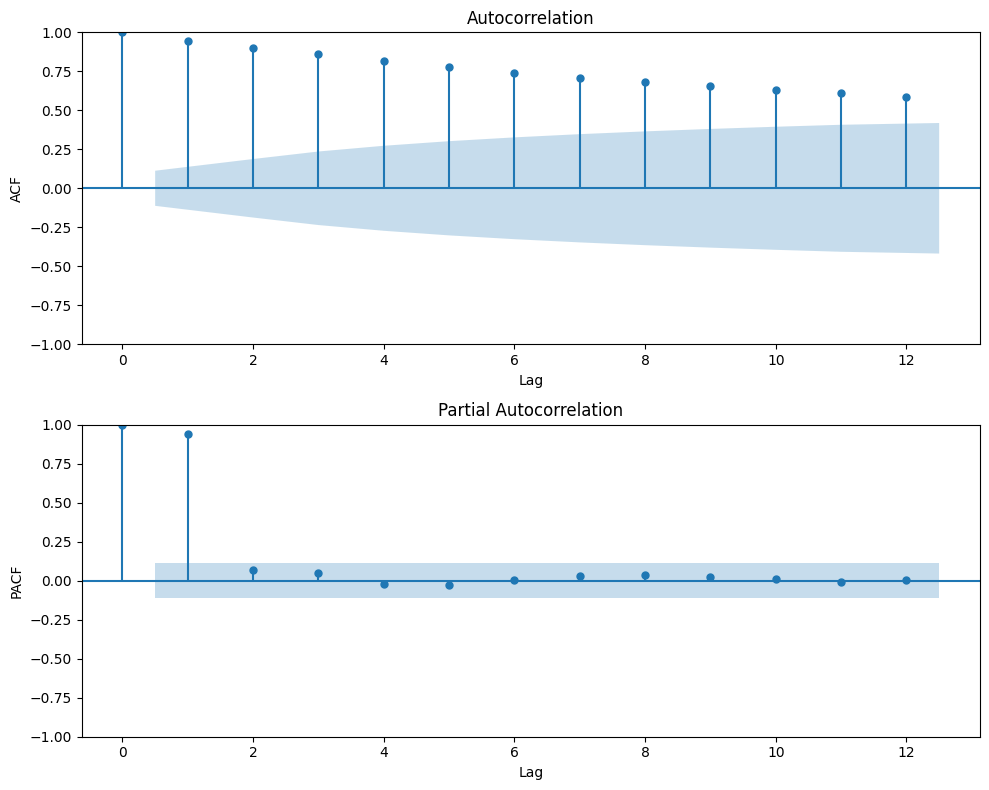

In [204]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_concat["UNEMPLOY"], lags=12, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_concat["UNEMPLOY"], lags=12, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

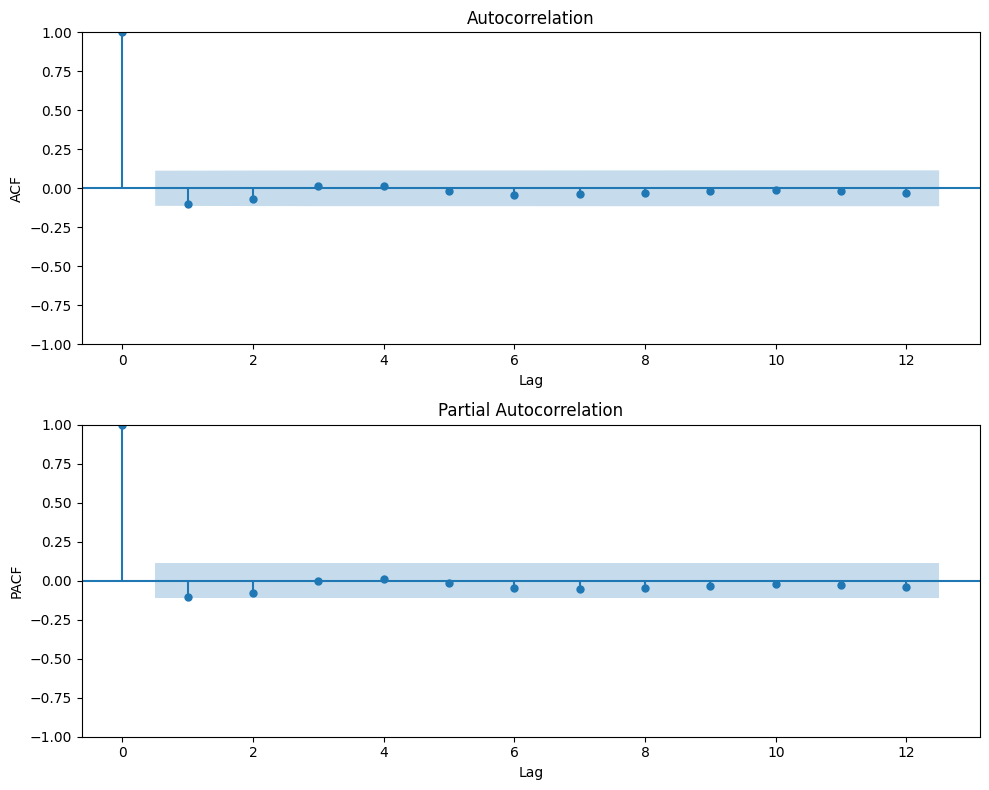

In [205]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_concat["UNEMPLOY"].diff().dropna(), lags=12, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_concat["UNEMPLOY"].diff().dropna(), lags=12, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

## Decomposition Model

### Time Plot

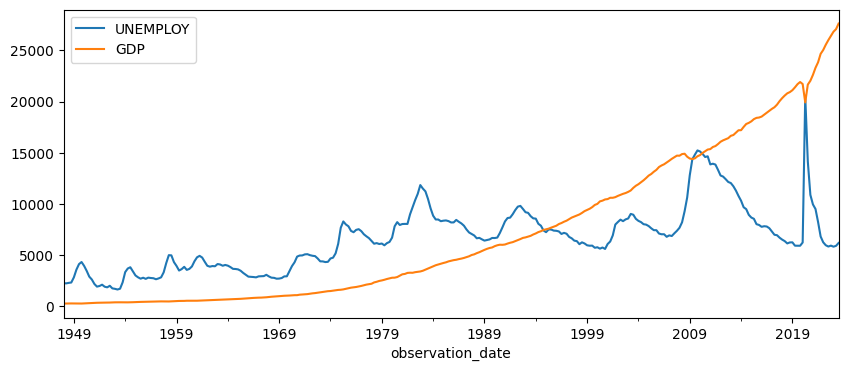

In [206]:
df_concat["UNEMPLOY"].plot(figsize = (10,4), legend = True)
df_concat["GDP"].plot(figsize = (10,4), legend = True)

plt.show()

Decomposition can be done using some function in `statsmodels` libary
- Seasonal Decomposition
- Decomposition using LOESS

1. Seasonal Decompose

Import the library first

In [207]:
from statsmodels.tsa.seasonal import seasonal_decompose

- Pass the data we want to decompose, and set the period as long as the frequency of the data occur in a year
- Since our data is quarterly data, so the period is 4

In [208]:
df_decompose = df_concat.copy()

In [209]:
res = seasonal_decompose(df_decompose["UNEMPLOY"],
                         period = 4)

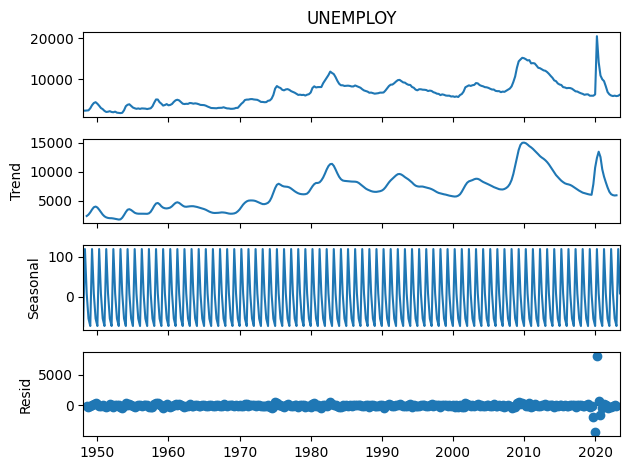

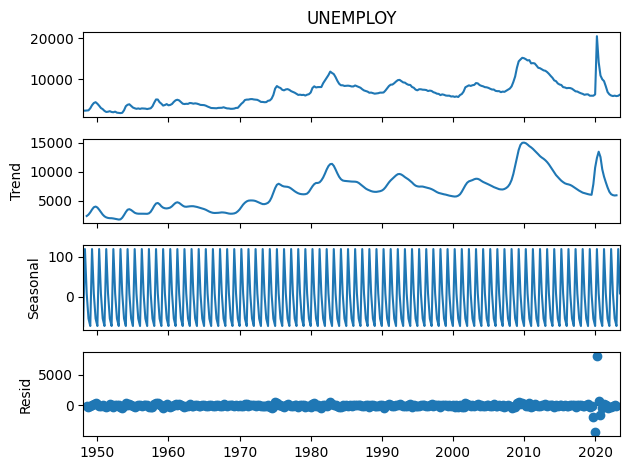

In [210]:
res.plot()

The dataset will be decomposed to three components:
- Trend
- Seasonal 
- Residual (can also be called reminder in other reference)

The model is assumed the data is additive, it means our data is decompose is the addition of trend, seasonal, and residual component.
Hence, if we add all the components, we will construct our original data.

In [211]:
res_additive = res.trend + res.seasonal + res.resid

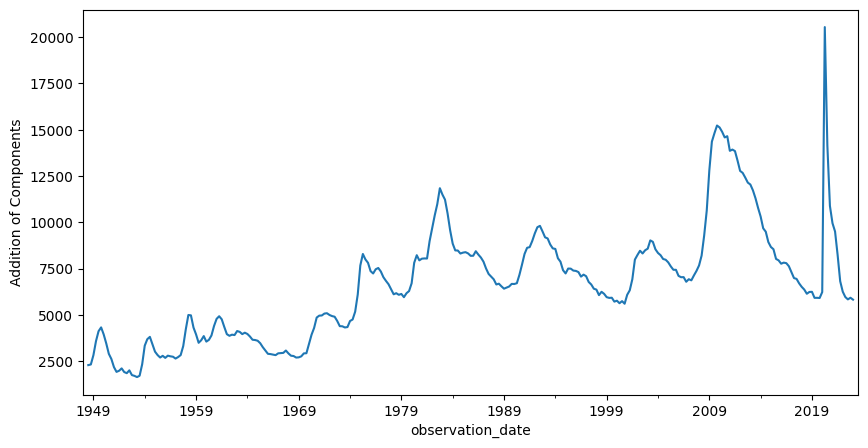

In [212]:
res_additive.plot(figsize = (10,5))
plt.ylabel("Addition of Components")
plt.show()

2. STL Decomposition using LOESS

- Another way to decompose time series component is using LOESS
- The estimation is similar as local regression where the data is fitted to limited range timeline

In [213]:
from statsmodels.tsa.seasonal import STL

- In STL decomposition, we also need to set the seasonal values
- The seasonal value is set as the number of period the seasonal pattern would be continue

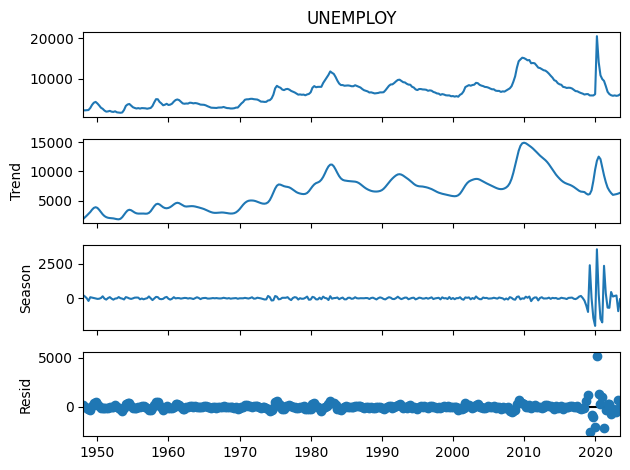

In [214]:
stl = STL(df_decompose["UNEMPLOY"],
          period = 4,
          seasonal = 5)
result = stl.fit()

fig = result.plot()

### Decomposition from Scratch

The step of decompsition in time series is slightly easy to understand
- Estimate the trend component
- Estimate the detrend to estimate the seasonal component
- Last, compute the residual by substracting the original value with the trend and seasonal value

#### Trend-Cycle Component

- To estimate trend, we compute the moving average smoothing by same limit range, since we have quarterly data, so we took the average of 4 data as window in `rolling` function
- It store the value of moving average smoothing in every four window of the data

In [215]:
# Compute the 2*4 moving average smoothing
df_decompose_4 = df_decompose["UNEMPLOY"].rolling(center = True,
                                                   window = 4).mean()

trend_unemploy = df_decompose_4.rolling(center = True,
                                        window = 2).mean()

The plot of the trend component: it shows the moving average smoothing by 4 window data

<AxesSubplot:xlabel='observation_date'>

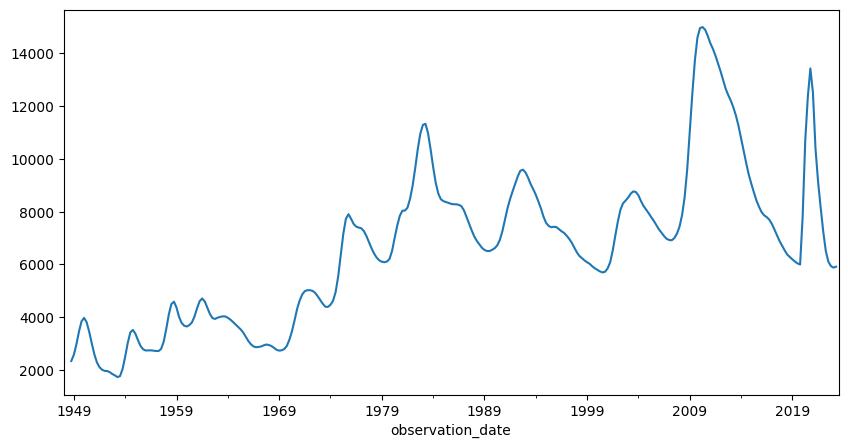

In [216]:
trend_unemploy.plot(figsize = (10,5))

#### Seasonal Component

First, calculate the detrend component

In [217]:
detrend_unemploy = pd.DataFrame(df_decompose["UNEMPLOY"] - trend_unemploy)
detrend_unemploy

,UNEMPLOY
observation_date,
1948-01-01,NaN
1948-04-01,NaN
1948-07-01,NaN
1948-10-01,-23.625
1949-01-01,238.250
...,...
2022-07-01,-269.875
2022-10-01,-15.625
2023-01-01,-56.500


In [218]:
df_decompose['quarter'] = df_decompose.index.quarter
df_decompose['year'] = df_decompose.index.year

- Get also the time features variable, such quarter and year
- Get the average of arrivals in each quarter and update the value as the seasonal pattern that occur repeatedly

In [219]:
detrend_unemploy["quarter"] = df_decompose["quarter"]
detrend_unemploy["year"] = df_decompose["year"]
detrend_unemploy["Seasonal"] = df_decompose.groupby("quarter")["UNEMPLOY"].transform(func = "mean")

<AxesSubplot:xlabel='observation_date'>

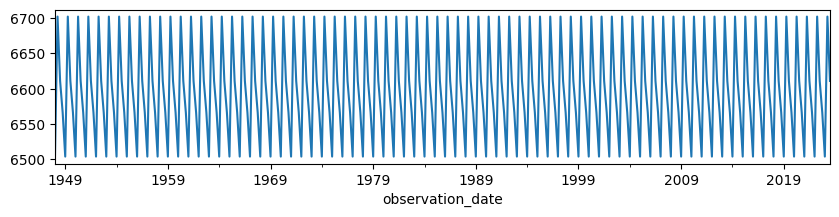

In [220]:
detrend_unemploy["Seasonal"].plot(figsize = (10,2))

#### Residual Component

The residual is extracted by substracting the arrivals using their trend and seasonal

In [221]:
seasonal_unemploy = detrend_unemploy["Seasonal"].copy()
resid_unemploy = df_decompose["UNEMPLOY"] - trend_unemploy - seasonal_unemploy
resid_unemploy

observation_date
1948-01-01            NaN
1948-04-01            NaN
1948-07-01            NaN
1948-10-01   -6589.665000
1949-01-01   -6265.223684
                 ...     
2022-07-01   -6880.835526
2022-10-01   -6581.665000
2023-01-01   -6559.973684
2023-04-01   -6714.072368
2023-07-01            NaN
Freq: QS-OCT, Length: 303, dtype: float64

The good residual is scattered randomly in the plot

<AxesSubplot:xlabel='observation_date'>

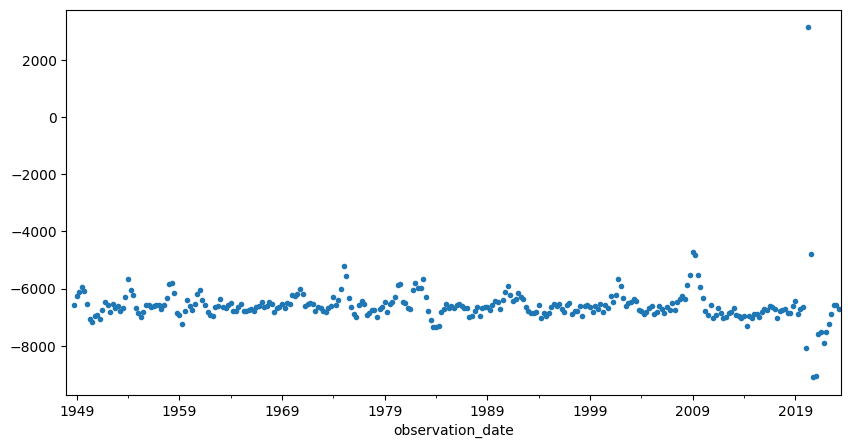

In [222]:
resid_unemploy.plot(figsize = (10,5),
              ls = " ",
              marker = ".")

Again, we can construct the original dataset using each component of model decomposition, the addition of trend, seasonal, and residual components

<AxesSubplot:xlabel='observation_date'>

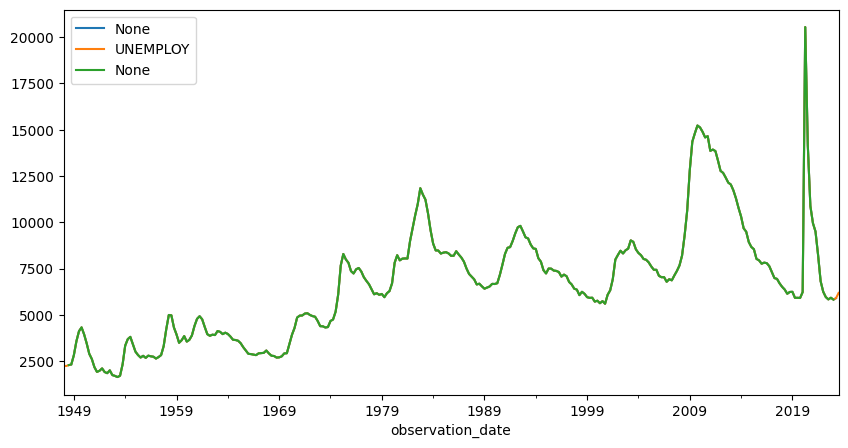

In [223]:
additive_decompose_unemploy = resid_unemploy + trend_unemploy + seasonal_unemploy
additive_decompose_unemploy.plot(figsize = (10,5), legend = "True")
df_decompose["UNEMPLOY"].plot(figsize = (10,5), legend = "True")
res_additive.plot(figsize = (10,5), legend = "True")

#### Wrap into Function

To perform it easily we can costruct function of trend, seasonal, and residual component decomposition

In [224]:
def trend_component(data, m):
    if (m%2 == 0):
        trend_m = data.rolling(center = True,
                               window = m).mean()

        trend = trend_m.rolling(center = True,
                                window = 2).mean()
    else:
        trend = data.rolling(center = True,
                             window = m).mean()
    return trend

def seasonal_component(data, columns, season):
    season_group = data.groupby(season)
    season = season_group[columns].transform(func = "mean")
    return season

def detrend(data, trend, type_model):
    if type_model == "Additive":
        detrend = data - trend
    elif type_model == "Multiplicative":
        detrend = data / trend
    else:
        "Unrecognize type model"

    return detrend

def resid_component(data, trend, seasonal, type_model):
    if type_model == "Additive":
        resid = data - trend - seasonal
    elif type_model == "Multiplicative":
        resid = data / (trend * seasonal)
    else:
        "Unrecognize type model"
    return resid

Now try to run the function to UK arrivals data which we decompose the component using library before

In [225]:
df_decompose["Trend_unemploy"] = trend_component(df_decompose["UNEMPLOY"],
                                          m = 4)

df_decompose["Detrend_unemploy"] = detrend(df_decompose["UNEMPLOY"],
                                    df_decompose["Trend_unemploy"],
                                    "Additive")

df_decompose["Seasonal_unemploy"] = seasonal_component(df_decompose,
                                                "Detrend_unemploy",
                                                "quarter")

df_decompose["Residual_unemploy"] = resid_component(df_decompose["UNEMPLOY"],
                                             df_decompose["Trend_unemploy"],
                                             df_decompose["Seasonal_unemploy"],
                                             "Additive")

Plot each component

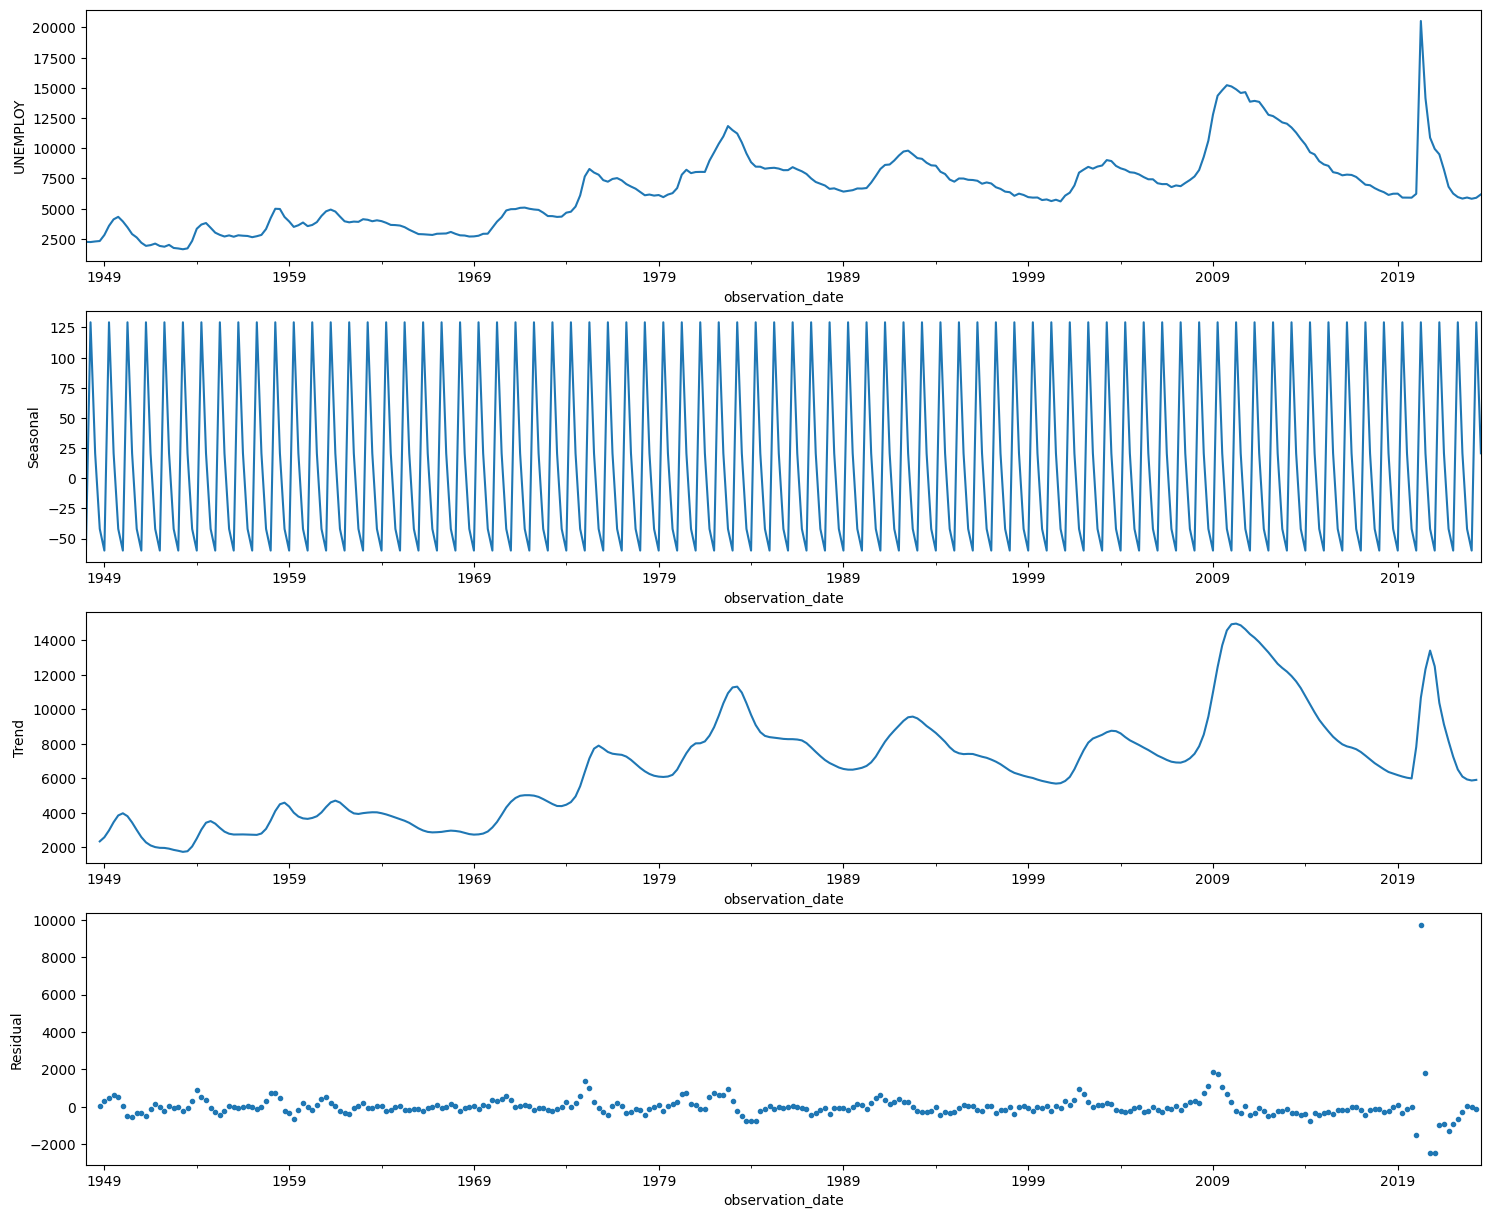

In [226]:
fig, axes = plt.subplots(4,1,
                        figsize=(18, 15))

df_decompose["UNEMPLOY"].plot(ax = axes[0], ylabel = "UNEMPLOY")
df_decompose["Seasonal_unemploy"].plot(ax = axes[1], ylabel = "Seasonal")
df_decompose["Trend_unemploy"].plot(ax = axes[2], ylabel = "Trend")
df_decompose["Residual_unemploy"].plot(ax = axes[3],
                                ls = " ",
                                marker = ".", ylabel = "Residual")

plt.show()

### Forecasting using Decomposition Model

Once we can decompose each components, we can use the components to do forecast. The steps are:
- Forecast seasonal adjusted data, it means that we can forecast the dataset except the seasonal parts
- Forecast the seasonal data
- Combine the forecast of seasonal adjusted and seasonal data

Before forecasting process, we need to set the range of date we want to forecast 

In [227]:
df_decompose.tail()

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy
observation_date,,,,,,,,
2022-07-01,5836.0,25994.639,3,2022,6105.875,-269.875,20.680743,-290.555743
2022-10-01,5925.0,26408.405,4,2022,5940.625,-15.625,-41.988333,26.363333
2023-01-01,5823.0,26813.601,1,2023,5879.500,-56.500,-59.951667,3.451667
2023-04-01,5904.0,27063.012,2,2023,5915.625,-11.625,129.271667,-140.896667
2023-07-01,6185.0,27610.128,3,2023,NaN,NaN,20.680743,NaN


The last rows did not get the trend component, so we set it to zero and include it to the forecast data

In [228]:
df_decompose.iloc[-1] = 0
df_decompose.tail()

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy
observation_date,,,,,,,,
2022-07-01,5836.0,25994.639,3,2022,6105.875,-269.875,20.680743,-290.555743
2022-10-01,5925.0,26408.405,4,2022,5940.625,-15.625,-41.988333,26.363333
2023-01-01,5823.0,26813.601,1,2023,5879.500,-56.500,-59.951667,3.451667
2023-04-01,5904.0,27063.012,2,2023,5915.625,-11.625,129.271667,-140.896667
2023-07-01,0.0,0.000,0,0,0.000,0.000,0.000000,0.000000


add 7 step ahead, so we have 8 quarter, 2 year to forecast 

In [229]:
date_forecast = pd.date_range('2012-10-01', 
                              periods = 7, 
                              freq = 'QS-OCT')
date_forecast

DatetimeIndex(['2012-10-01', '2013-01-01', '2013-04-01', '2013-07-01',
               '2013-10-01', '2014-01-01', '2014-04-01'],
              dtype='datetime64[ns]', freq='QS-OCT')

Create dataframe of the forecast data with the same columns of our dataset

In [230]:
forecast_data = pd.DataFrame(data = np.zeros((7,8)),
                             columns = df_decompose.columns,
                             index = date_forecast)
forecast_data

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy
2012-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Concat the original data and the forecast data

In [231]:
df_decompose = pd.concat([df_decompose,forecast_data])
df_decompose.tail(10)

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy
2023-01-01,5823.0,26813.601,1.0,2023.0,5879.500,-56.500,-59.951667,3.451667
2023-04-01,5904.0,27063.012,2.0,2023.0,5915.625,-11.625,129.271667,-140.896667
2023-07-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2012-10-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2013-01-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2013-04-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2013-07-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2013-10-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2014-01-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000
2014-04-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000


### 1. Forecast Seasonal Adjusted Data

- There are several ways to forecast the seasonal adjusted data
- For simplicity we will use the naive forecast, that is we forecast the next period as the same as the previous period

Take the last date before the forecast date

In [232]:
last_date = pd.to_datetime("2012-04-01")

Set the seasonal adjusted data of the forecast data as the same of seasonal adjusted data of the last date

In [233]:
df_decompose["Seasonal Adjusted"] = df_decompose["UNEMPLOY"] - df_decompose["Seasonal_unemploy"]
df_decompose.tail(10)

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy,Seasonal Adjusted
2023-01-01,5823.0,26813.601,1.0,2023.0,5879.500,-56.500,-59.951667,3.451667,5882.951667
2023-04-01,5904.0,27063.012,2.0,2023.0,5915.625,-11.625,129.271667,-140.896667,5774.728333
2023-07-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2012-10-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2013-01-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2013-04-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2013-07-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2013-10-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2014-01-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000
2014-04-01,0.0,0.000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000


In [125]:
df_concat.loc[last_date:, "Seasonal Adjusted"] = df_concat.loc[last_date, "Seasonal Adjusted"]
df_concat.loc[last_date:]

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy,Seasonal Adjusted
2012-04-01,12666.0,16207.115,2.0,2012.0,12974.625,-308.625,129.271667,-437.896667,12536.728333
2012-07-01,12414.0,16319.541,3.0,2012.0,12647.500,-233.500,20.680743,-254.180743,12536.728333
2012-10-01,12142.0,16420.419,4.0,2012.0,12406.875,-264.875,-41.988333,-222.886667,12536.728333
2013-01-01,12037.0,16648.189,1.0,2013.0,12196.750,-159.750,-59.951667,-99.798333,12536.728333
2013-04-01,11722.0,16728.687,2.0,2013.0,11938.875,-216.875,129.271667,-346.146667,12536.728333
2013-07-01,11295.0,16953.838,3.0,2013.0,11628.250,-333.250,20.680743,-353.930743,12536.728333
2013-10-01,10776.0,17192.019,4.0,2013.0,11241.625,-465.625,-41.988333,-423.636667,12536.728333
2014-01-01,10310.0,17197.738,1.0,2014.0,10769.750,-459.750,-59.951667,-399.798333,12536.728333
2014-04-01,9674.0,17518.508,2.0,2014.0,10288.125,-614.125,129.271667,-743.396667,12536.728333
2014-07-01,9490.0,17804.228,3.0,2014.0,9832.000,-342.000,20.680743,-362.680743,12536.728333


### 2. Forecast Seasonal Data

- There are several ways to forecast the seasonal  data
- For simplicity we will use the naive forecast, that is we forecast the next seasonal as the same as the season in last year

Take the last 4 quarter before the forecast date to fill the seasonal component of forecast data 

In [234]:
last_season = df_decompose.iloc[122:126][["quarter", "UNEMPLOY", "Seasonal_unemploy"]]
last_season

,quarter,UNEMPLOY,Seasonal_unemploy
1978-07-01,3.0,6171.0,20.680743
1978-10-01,4.0,6084.0,-41.988333
1979-01-01,1.0,6130.0,-59.951667
1979-04-01,2.0,5956.0,129.271667


Set the seasonal feature, quarter as the index to easier accessing the data

In [235]:
quarter_map = last_season.set_index("quarter")["Seasonal_unemploy"]
quarter_map

quarter
3.0     20.680743
4.0    -41.988333
1.0    -59.951667
2.0    129.271667
Name: Seasonal_unemploy, dtype: float64

Prepare the index of the forecast data

In [236]:
forecast_index = pd.date_range('2012-07-01', 
                               periods = 8, 
                               freq = 'QS-OCT')
forecast_index

DatetimeIndex(['2012-07-01', '2012-10-01', '2013-01-01', '2013-04-01',
               '2013-07-01', '2013-10-01', '2014-01-01', '2014-04-01'],
              dtype='datetime64[ns]', freq='QS-OCT')

To get the seasonal data, we need to extract the sesonal feature of the forecast data

In [237]:
df_decompose.loc[forecast_index,"quarter"] = df_decompose.loc[forecast_index].index.quarter
df_decompose.loc[forecast_index,"year"] = df_decompose.loc[forecast_index].index.year

Now get each value from the last season corresponding to the same quarter to fill the seasonal component in the forecast data

In [238]:
df_decompose.loc[forecast_index, "Seasonal_unemploy"] = [quarter_map[i] for i in df_decompose.loc[forecast_index, "quarter"]]

In [239]:
df_decompose.loc[forecast_index]

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy,Seasonal Adjusted
2012-07-01,12414.0,16319.541,3.0,2012.0,12647.500,-233.500,20.680743,-254.180743,12393.319257
2012-10-01,12142.0,16420.419,4.0,2012.0,12406.875,-264.875,-41.988333,-222.886667,12183.988333
2012-10-01,0.0,0.000,4.0,2012.0,0.000,0.000,-41.988333,0.000000,0.000000
2013-01-01,12037.0,16648.189,1.0,2013.0,12196.750,-159.750,-59.951667,-99.798333,12096.951667
2013-01-01,0.0,0.000,1.0,2013.0,0.000,0.000,-59.951667,0.000000,0.000000
2013-04-01,11722.0,16728.687,2.0,2013.0,11938.875,-216.875,129.271667,-346.146667,11592.728333
2013-04-01,0.0,0.000,2.0,2013.0,0.000,0.000,129.271667,0.000000,0.000000
2013-07-01,11295.0,16953.838,3.0,2013.0,11628.250,-333.250,20.680743,-353.930743,11274.319257
2013-07-01,0.0,0.000,3.0,2013.0,0.000,0.000,20.680743,0.000000,0.000000
2013-10-01,10776.0,17192.019,4.0,2013.0,11241.625,-465.625,-41.988333,-423.636667,10817.988333


The seasonal adjusted and seasonal data now are filled

### 3. Sum up the Seasonal Adjusted Data and Seasonal Data

Last step, produce the forecast as the summation of seasonal adjusted and seasonal data

In [240]:
df_decompose.loc[forecast_index, "UNEMPLOY"] = df_decompose.loc[forecast_index, "Seasonal_unemploy"] + df_decompose.loc[forecast_index, "Seasonal Adjusted"]

Here's the plot of the forecast results

<AxesSubplot:>

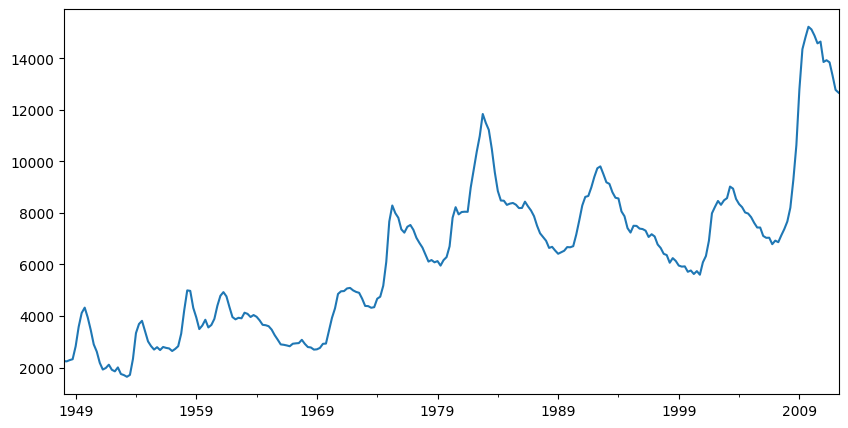

In [241]:
df_decompose.loc[:last_date, "UNEMPLOY"].plot(figsize = (10,5))

If we plot the with the original data
- It seems the seasonal pattern we see in the original data continue in the forecast data
- Howver we cant be sure the value of the forecast is legit or not

<AxesSubplot:>

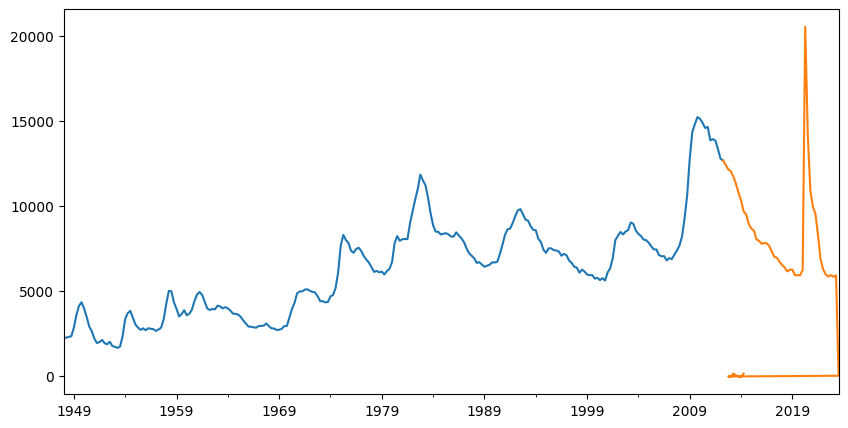

In [242]:
df_decompose.loc[:last_date, "UNEMPLOY"].plot(figsize = (10,5))
df_decompose.loc[last_date:, "UNEMPLOY"].plot(figsize = (10,5))

### Forecasting Model

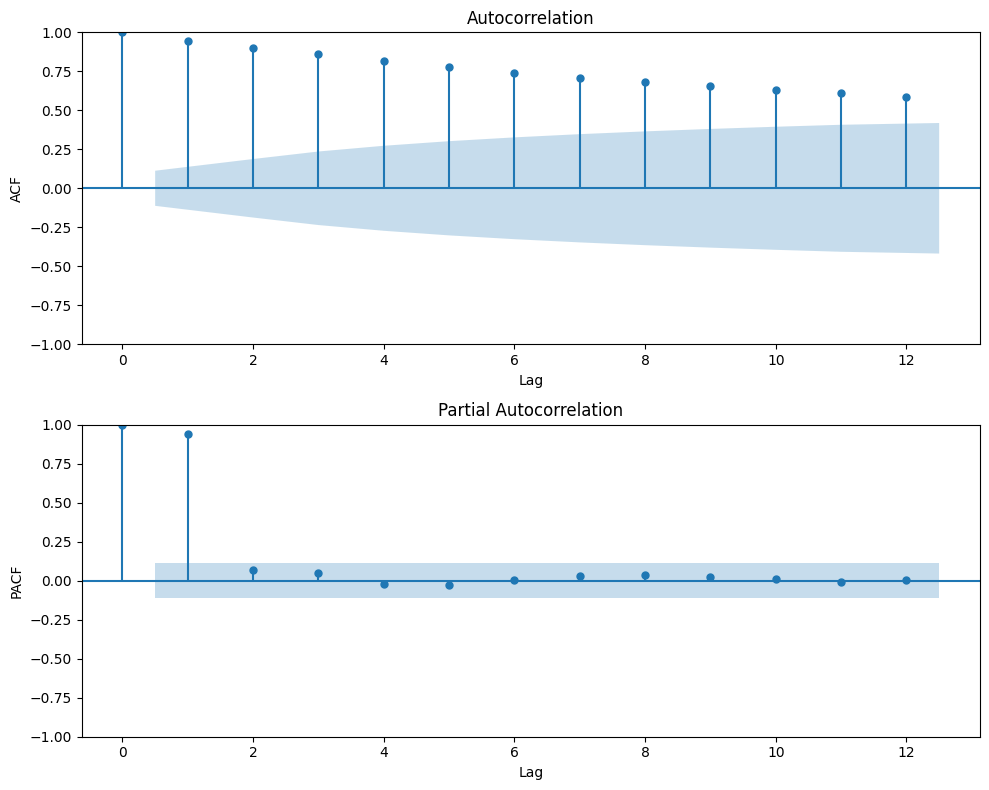

In [243]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_concat["UNEMPLOY"], lags=12, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_concat["UNEMPLOY"], lags=12, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

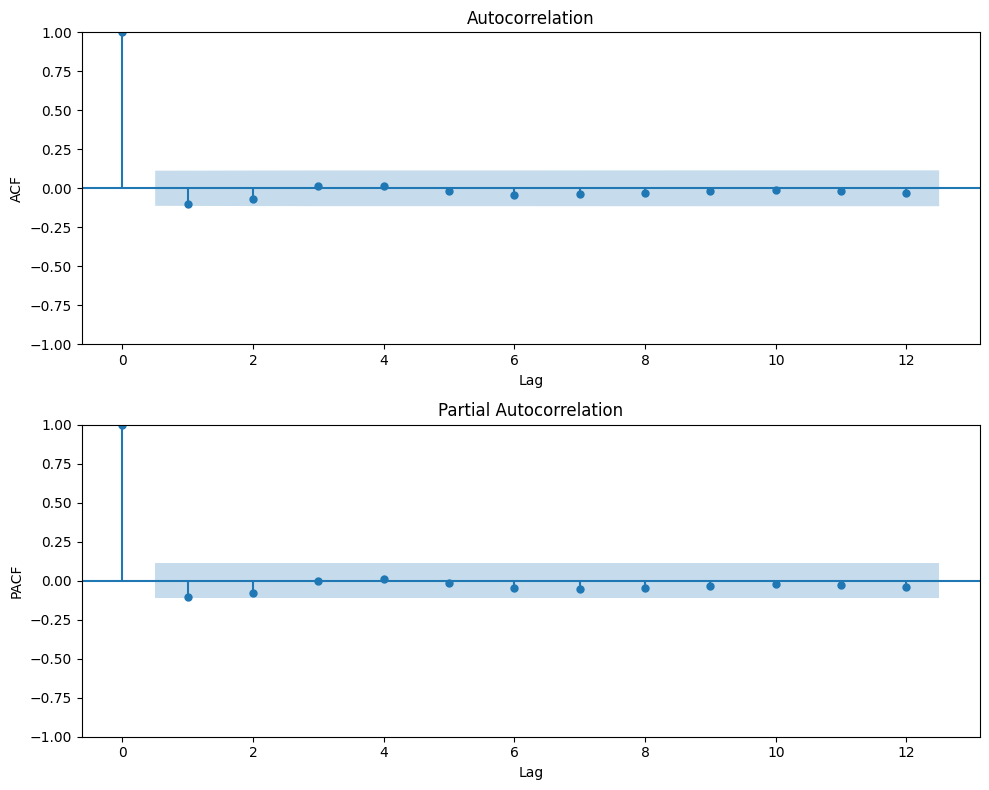

In [244]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_concat["UNEMPLOY"].diff().dropna(), lags=12, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_concat["UNEMPLOY"].diff().dropna(), lags=12, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

## Forecasting using VAR

In [245]:
# set 100 observation as testing set
nobs_test = 100

# split into train and and test dataframe
df_train = df_concat[:-nobs_test].copy()
df_test = df_concat[-nobs_test:].copy()

# Check size
print(df_train.shape)
print(df_test.shape) 

(203, 2)
(100, 2)


In [246]:
# define columns to use in VAR model
col_to_use = ["UNEMPLOY","GDP"]

# build the model
model = VAR(df_train[col_to_use])

In [247]:
df_train[col_to_use]

,UNEMPLOY,GDP
observation_date,,
1948-01-01,2254.0,265.742
1948-04-01,2239.0,272.567
1948-07-01,2288.0,279.196
1948-10-01,2324.0,280.366
1949-01-01,2825.0,275.034
...,...,...
1997-07-01,6640.0,8662.823
1997-10-01,6413.0,8765.907
1998-01-01,6365.0,8866.480


In [248]:
# in VAR we can use `select_order` to automatically train model with certain maxlag
x = model.select_order(maxlags = 12)
x.summary()

,AIC,BIC,FPE,HQIC
0,30.65,30.68,2.041e+13,30.66
1,17.77,17.88,5.241e+07,17.82
2,17.24,17.41*,3.068e+07,17.31*
3,17.22,17.46,3.018e+07,17.32
4,17.24,17.55,3.071e+07,17.36
5,17.25,17.62,3.099e+07,17.40
6,17.23,17.68,3.056e+07,17.41
7,17.26,17.77,3.138e+07,17.47
8,17.19*,17.77,2.937e+07*,17.43
9,17.22,17.86,3.007e+07,17.48


In [249]:
# fit manually the best order to the model
result = model.fit(maxlags = 8)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jan, 2024
Time:                     00:34:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.7439
Nobs:                     195.000    HQIC:                   17.4043
Log likelihood:          -2193.77    FPE:                2.87486e+07
AIC:                      17.1732    Det(Omega_mle):     2.43229e+07
--------------------------------------------------------------------
Results for equation UNEMPLOY
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             155.599910        53.937496            2.885           0.004
L1.UNEMPLOY         1.715954         0.075898           22.609           0.000
L1.GDP              0.926765         0.936634            0.989   

In [250]:
# Input data for forecasting, get the last 100 observation as our test size in 100 
forecast_input = df_train[col_to_use].values[-nobs_test:]
forecast_input

array([[ 4343.   ,  1476.289],
       [ 4670.   ,  1491.209],
       [ 4750.   ,  1530.056],
       [ 5174.   ,  1560.026],
       [ 6100.   ,  1599.679],
       [ 7666.   ,  1616.116],
       [ 8288.   ,  1651.853],
       [ 7993.   ,  1709.82 ],
       [ 7812.   ,  1761.831],
       [ 7363.   ,  1820.487],
       [ 7235.   ,  1852.332],
       [ 7463.   ,  1886.558],
       [ 7532.   ,  1934.273],
       [ 7343.   ,  1988.648],
       [ 7035.   ,  2055.909],
       [ 6835.   ,  2118.473],
       [ 6655.   ,  2164.27 ],
       [ 6381.   ,  2202.76 ],
       [ 6112.   ,  2331.633],
       [ 6171.   ,  2395.053],
       [ 6084.   ,  2476.949],
       [ 6130.   ,  2526.61 ],
       [ 5956.   ,  2591.247],
       [ 6169.   ,  2667.565],
       [ 6286.   ,  2723.883],
       [ 6705.   ,  2789.842],
       [ 7813.   ,  2797.352],
       [ 8222.   ,  2856.483],
       [ 7943.   ,  2985.557],
       [ 8035.   ,  3124.206],
       [ 8047.   ,  3162.532],
       [ 8043.   ,  3260.609],
       [

In [251]:
# Make forecast into 100 data ahead
fc_res = result.forecast(y = forecast_input,
                         steps = nobs_test)

df_forecast = pd.DataFrame(fc_res,
                           index = df_test.index,
                           columns = col_to_use)
df_forecast

,UNEMPLOY,GDP
observation_date,,
1998-10-01,6544.368245,9223.992901
1999-01-01,6868.832433,9338.511171
1999-04-01,7284.452615,9439.592433
1999-07-01,7483.896390,9559.267282
1999-10-01,7621.318749,9675.695803
...,...,...
2022-07-01,14141.880053,28620.649095
2022-10-01,14250.213181,28952.459053
2023-01-01,14359.717977,29287.931944


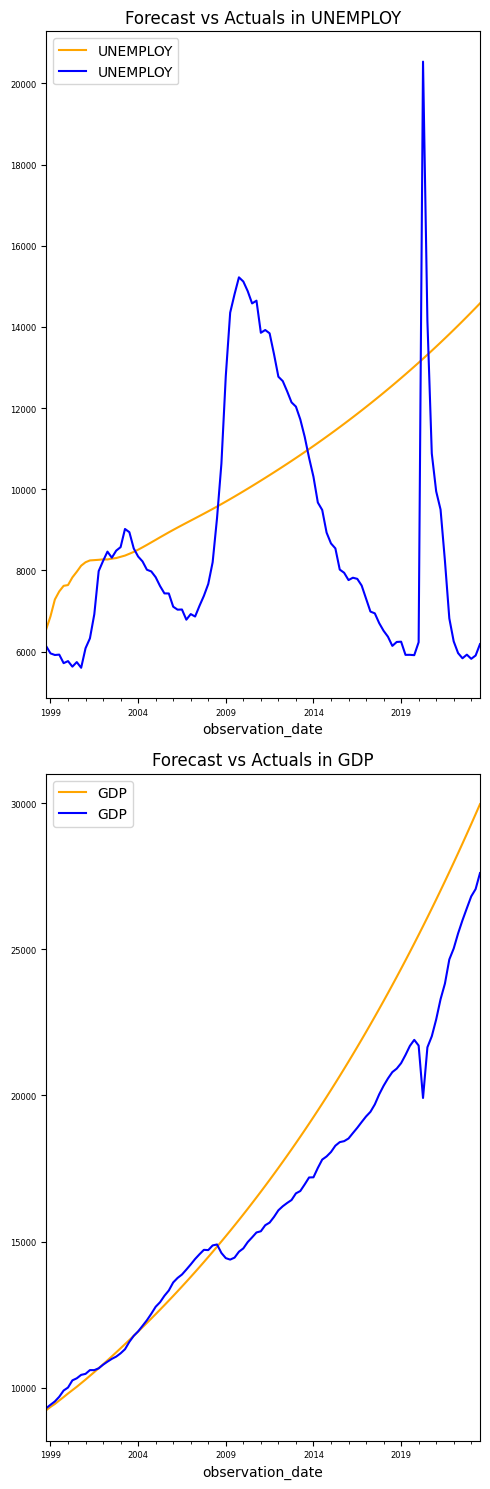

In [252]:
fig, axes = plt.subplots(len(col_to_use),1,
                         figsize=(5, 15))

for i, (col,ax) in enumerate(zip(col_to_use, axes.flatten())):
    df_forecast[col].plot(legend=True, 
                          ax=ax, 
                          color = "orange").autoscale(axis='x',
                                                      tight=True)
    
    df_test[col][-nobs_test:].plot(legend=True, 
                              ax=ax, color = "b");
    
    ax.set_title("Forecast vs Actuals in " + col)
    ax.tick_params(labelsize=6)

plt.tight_layout();

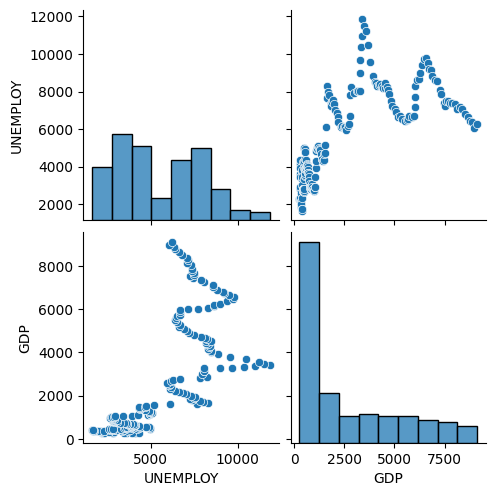

In [253]:
sns.pairplot(df_train[col_to_use])
plt.show()

In [254]:
# add variable
df_concat["UNEMPLOY2"] = df_concat["UNEMPLOY"]**2
df_train["UNEMPLOY2"] = df_train["UNEMPLOY"]**2
df_test["UNEMPLOY2"] = df_test["UNEMPLOY"]**2

In [255]:
# define columns to use in VAR model
col_to_use = ["GDP", "UNEMPLOY", "UNEMPLOY2"]

# build the model
model = VAR(df_train[col_to_use])

# in VAR we can use `select_order` to automatically select the best model
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,61.76,61.82,6.670e+26,61.79
1,46.50,46.70,1.565e+20,46.58
2,45.52,45.87*,5.851e+19,45.66*
3,45.50*,46.01,5.782e+19*,45.71
4,45.56,46.22,6.110e+19,45.83
5,45.58,46.40,6.269e+19,45.91
6,45.61,46.58,6.414e+19,46.00
7,45.64,46.76,6.634e+19,46.09
8,45.53,46.81,5.968e+19,46.05
9,45.58,47.01,6.299e+19,46.16


In [256]:
# fit manually the best order to the model
result = model.fit(maxlags = 12)

# Input data for forecasting, get the last 100 observation as our test size in 100 
forecast_input = df_train[col_to_use].values[-nobs_test:]

# Make forecast into 100 data ahead
fc_res = result.forecast(y = forecast_input, 
                         steps = nobs_test)

# Create DataFrame of forecast result
df_forecast = pd.DataFrame(fc_res,
                           index = df_test.index,
                           columns = col_to_use)
df_forecast

,GDP,UNEMPLOY,UNEMPLOY2
observation_date,,,
1998-10-01,9224.607946,6495.024662,4.145082e+07
1999-01-01,9346.951151,7020.581998,4.922374e+07
1999-04-01,9438.723540,7647.213610,5.816756e+07
1999-07-01,9563.704025,8042.884194,6.449437e+07
1999-10-01,9688.344505,8263.552236,6.733386e+07
...,...,...,...
2022-07-01,27932.468849,12663.227718,1.164038e+08
2022-10-01,28238.968941,12732.984259,1.171739e+08
2023-01-01,28548.552782,12803.826943,1.179585e+08


In [257]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jan, 2024
Time:                     00:34:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    47.4538
Nobs:                     191.000    HQIC:                   46.3293
Log likelihood:          -5053.38    FPE:                6.23049e+19
AIC:                      45.5637    Det(Omega_mle):     3.66284e+19
--------------------------------------------------------------------
Results for equation GDP
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const               -25.327727        13.852682           -1.828           0.067
L1.GDP                1.138628         0.087988           12.941           0.000
L1.UNEMPLOY          -0.001007         0.018187           -0.0

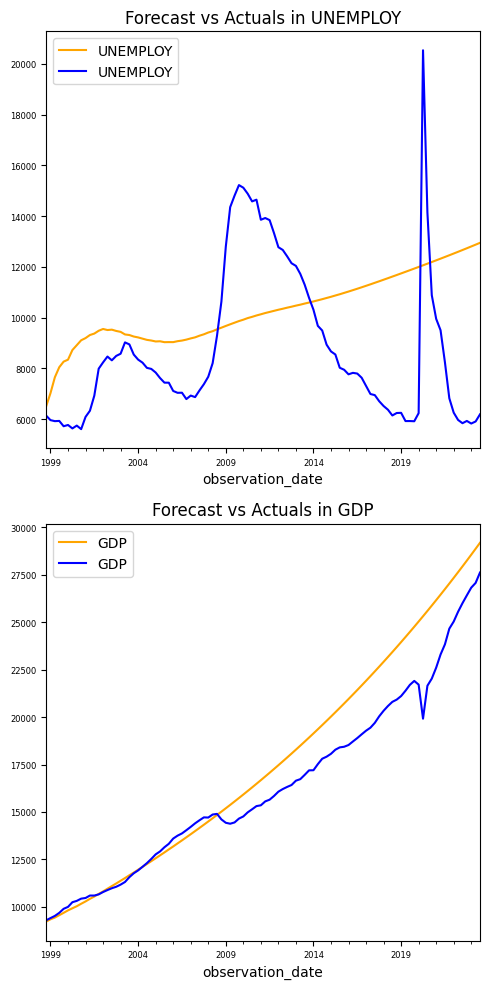

In [258]:
col_to_use = ["UNEMPLOY", "GDP"]

fig, axes = plt.subplots(len(col_to_use),1,
                        figsize=(5, 10))

for i, (col,ax) in enumerate(zip(col_to_use, axes.flatten())):
    df_forecast[col].plot(legend=True, 
                          ax = ax, 
                          color = "orange").autoscale(axis='x',
                                                      tight=True)
    
    df_test[col][-nobs_test:].plot(legend = True, 
                                   ax = ax,
                                   color = "b");
    
    ax.set_title("Forecast vs Actuals in " + col)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Evaluation

In [259]:
rmse_unemploy = np.sqrt(mse(df_test["UNEMPLOY"], df_forecast["UNEMPLOY"]))
rmse_gdp = np.sqrt(mse(df_test["GDP"], df_forecast["GDP"]))

In [260]:
print(f"RMSE from unemploy forecast = {rmse_unemploy}\nRMSE from gdo forecast = {rmse_gdp}")

RMSE from unemploy forecast = 3590.0949343327698
RMSE from gdo forecast = 1780.6813090383296


### Diagnostic

The ACF of residuals

Goal: test assumption in model in term of independence of error

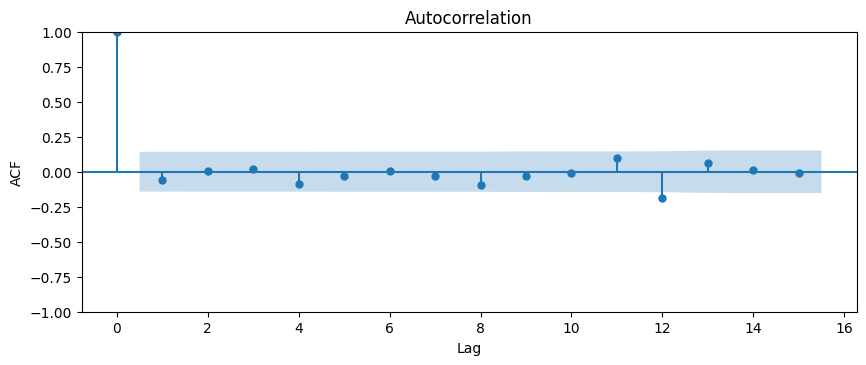

In [261]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(result.resid["UNEMPLOY"], lags=15, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

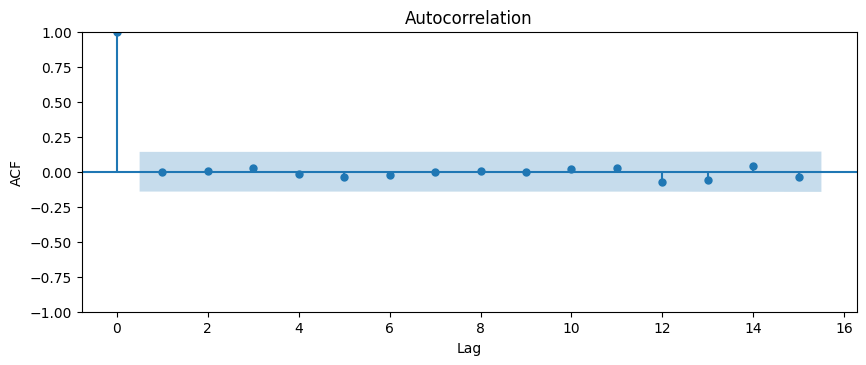

In [262]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(result.resid["GDP"], lags=15, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

The CCF of the residual to see whether the residual of each models have relationship

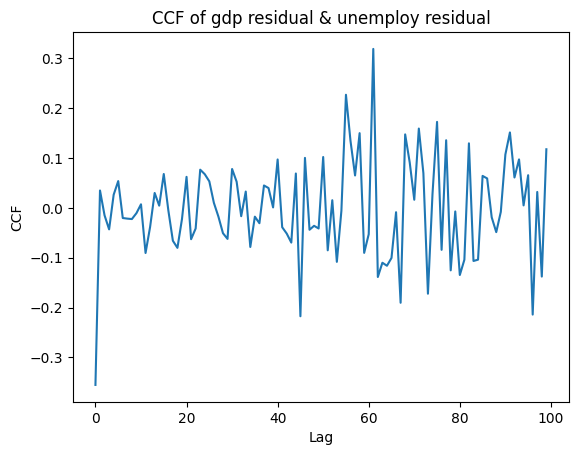

In [263]:
# Calculate the CCF
ccf_gdp_unemploy = ccf(result.resid["GDP"], result.resid["UNEMPLOY"])[:100]

# Plot CCF
plt.plot(ccf_gdp_unemploy)
plt.xlabel("Lag")
plt.ylabel("CCF")
plt.title("CCF of gdp residual & unemploy residual")
plt.show()

In [264]:
# Extract the zero order correlation
corr_resid = pd.DataFrame(result.resid_corr, index = result.params.columns, columns = result.params.columns)
corr_resid

,GDP,UNEMPLOY,UNEMPLOY2
GDP,1.000000,-0.355257,-0.405128
UNEMPLOY,-0.355257,1.000000,0.918823
UNEMPLOY2,-0.405128,0.918823,1.000000


- We notice that most of the correlations in the residual series are below 0.15, however the zero order correlations of mortality with temperature residuals is about .66
- This means that the AR model is not capturing the concurrent effect of temperature and pollution on mortality.

## ARIMA

In [265]:
# convert datetime
df_concat.index = pd.PeriodIndex(df_concat.index, freq='Q')
df_concat

,UNEMPLOY,GDP,UNEMPLOY2
observation_date,,,
1948Q1,2254.0,265.742,5080516.0
1948Q2,2239.0,272.567,5013121.0
1948Q3,2288.0,279.196,5234944.0
1948Q4,2324.0,280.366,5400976.0
1949Q1,2825.0,275.034,7980625.0
...,...,...,...
2022Q3,5836.0,25994.639,34058896.0
2022Q4,5925.0,26408.405,35105625.0
2023Q1,5823.0,26813.601,33907329.0


In [266]:
result = adfuller(df_concat['UNEMPLOY'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.055382
p-value: 0.030036
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [267]:
result = adfuller(df_concat['GDP'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 8.523131
p-value: 1.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


***Visualization and stationarity test of log-transformed variables***

Perform a logarithmic transformation on the GDP and money supply variables, then visually inspect the data by looking at a *lineplot* similar to the previous question. Also perform the Augmented Dickey-Fuller test to test the stationarity of the variables.

In [268]:
df_concat['log_gdp'] = np.log(df_concat['GDP']).dropna()
df_concat['log_unemploy'] = np.log(df_concat['UNEMPLOY']).dropna()

TypeError: Invalid object type at position 0

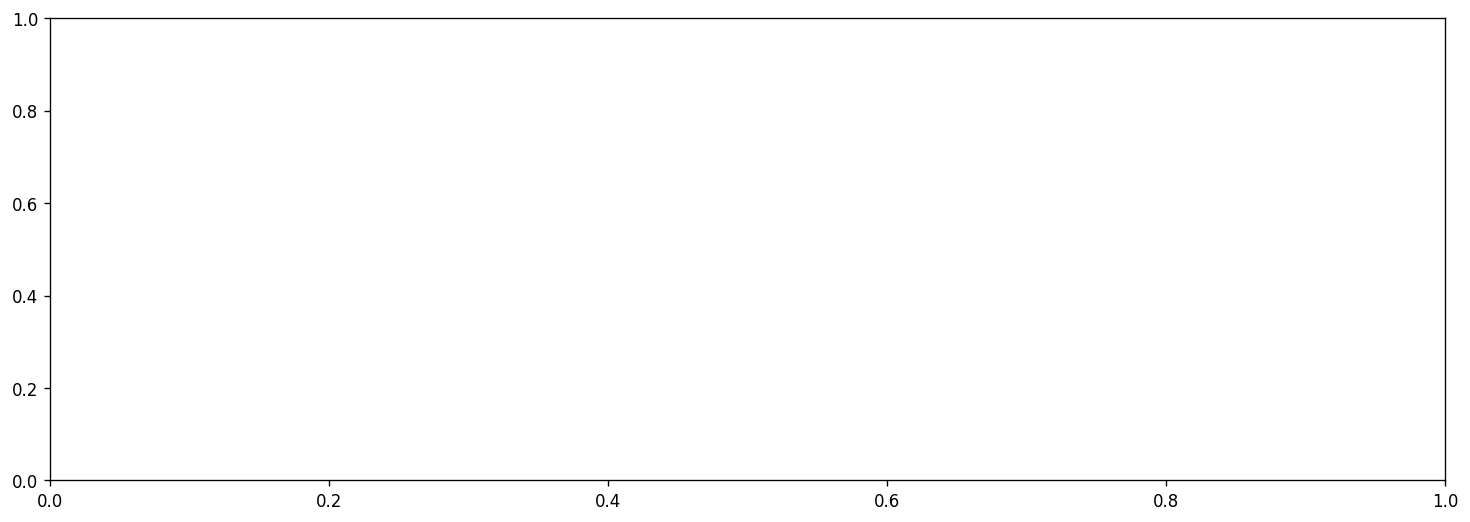

In [269]:
plt.figure(figsize=(15,5),
           dpi=120 #for higher quality image
          )

sns.lineplot(data=df_concat, x=df_concat.index, y=df_concat["log_gdp"])
sns.lineplot(data=df_concat, x=df_concat.index, y=df_concat["log_unemploy"])

# xlabel=[f"{i}q1" for i in range(1990,2014,1)]
plt.xticks(xlabel,rotation=45)

plt.show()

***Visualization and stationarity test of first-differenced variables***

Perform a *first differencing* on the results of the logarithmic transformation of GDP and money supply, then visually inspect the data by looking at a *lineplot* similar to the previous question. Also perform the Augmented Dickey-Fuller test to test the stationarity of the variables.

In [270]:
df_concat['diff_log_gdp'] = df_concat['log_gdp'].diff()
df_concat['diff_log_unemploy'] = df_concat['log_unemploy'].diff()

df_concat = df_concat.dropna()

TypeError: Invalid object type at position 0

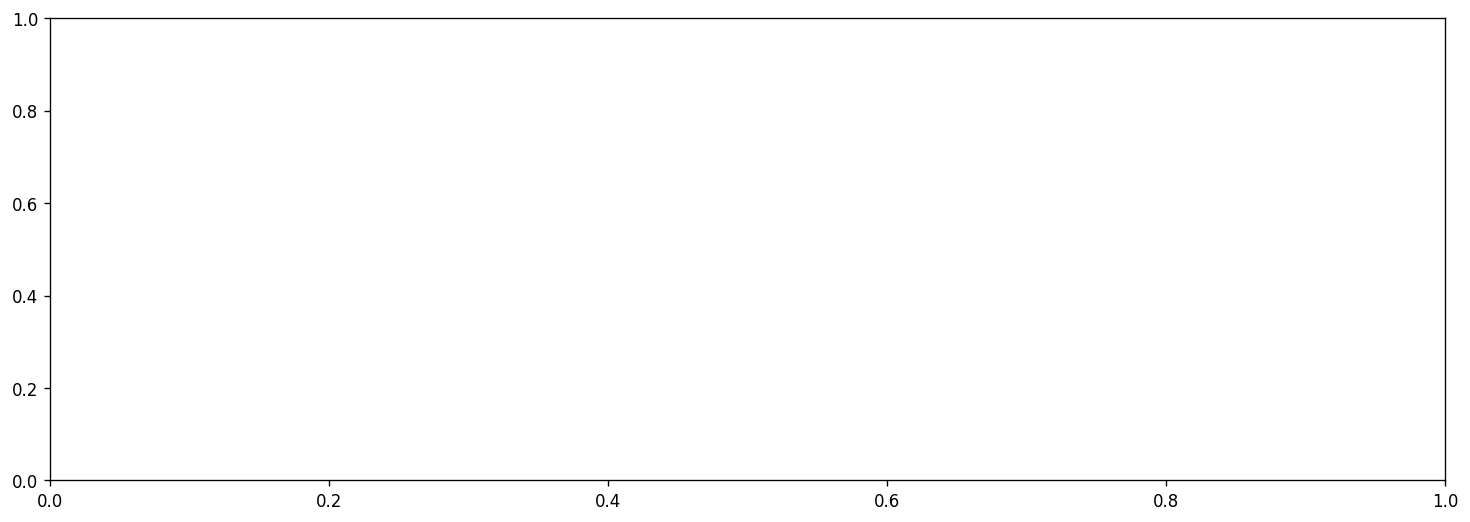

In [271]:
plt.figure(figsize=(15,5),
           dpi=120 #for higher quality image
          )

sns.lineplot(data=df_concat, x=df_concat.index, y="diff_log_gdp", )
sns.lineplot(data=df_concat, x=df_concat.index, y="diff_log_unemploy")

# xlabel=[f"{i}q1" for i in range(1990,2014,1)]
plt.xticks(xlabel,rotation=45)

plt.show()

In [272]:
result = adfuller(df_concat['diff_log_gdp'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.601492
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [273]:
result = adfuller(df_concat['diff_log_unemploy'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.011651
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


***Engle-Granger Test for Cointegration***

Perform Engel-Granger Test.


In [274]:
coint_t, p_val, _ = coint(df_concat['diff_log_gdp'],
                          df_concat["diff_log_unemploy"],
                          maxlag = 15)
p_val 

0.6458561740080075

In [275]:
coint_t, p_val, _ = coint(df_concat["diff_log_unemploy"],
                          df_concat['diff_log_gdp'],
                          maxlag = 15)
p_val

0.0028773208970457494

***VAR regression***

Perform *vector autoregression* regression with *lag* model according to Akaike Information Criterion.

In [276]:
# Define which columns to use
col_to_use = ["diff_log_unemploy","diff_log_gdp"]

# Create model object
model = VAR(df_concat[col_to_use])

# Use `select_order` to automatically train model with certain maxlag
x = model.select_order(maxlags = 12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-14.12,-14.09,7.410e-07,-14.11
1,-14.35,-14.27,5.888e-07,-14.31
2,-14.45,-14.33*,5.280e-07,-14.40
3,-14.50,-14.32,5.057e-07,-14.43
4,-14.54,-14.31,4.849e-07,-14.45*
5,-14.54*,-14.27,4.822e-07*,-14.43
6,-14.54,-14.21,4.840e-07,-14.41
7,-14.53,-14.15,4.911e-07,-14.37
8,-14.51,-14.08,5.009e-07,-14.33
9,-14.50,-14.02,5.029e-07,-14.31


In [277]:
# Get summary of the model
results = model.fit(maxlags=5,
                    ic = 'aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jan, 2024
Time:                     00:35:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.2317
Nobs:                     298.000    HQIC:                  -14.3657
Log likelihood:           1326.12    FPE:                5.27555e-07
AIC:                     -14.4551    Det(Omega_mle):     4.97076e-07
--------------------------------------------------------------------
Results for equation diff_log_unemploy
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.012764         0.014743            0.866           0.387
L1.diff_log_unemploy        -0.118081         0.088169           -1.339           0.180
L1.diff_log_gdp     

In [278]:
# Now prepare for forecasting
nobs = len(df_concat)

# Input data for forecasting
forecast_input = df_concat[col_to_use][:nobs].values

In [279]:
df_concat.index

PeriodIndex(['1948Q2', '1948Q3', '1948Q4', '1949Q1', '1949Q2', '1949Q3',
             '1949Q4', '1950Q1', '1950Q2', '1950Q3',
             ...
             '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3',
             '2022Q4', '2023Q1', '2023Q2', '2023Q3'],
            dtype='period[Q-DEC]', name='observation_date', length=302)

In [280]:
# Forecast
fc = results.forecast(y = forecast_input, steps = nobs)

df_forecast = pd.DataFrame(fc,
                           index = df_concat.index,
                           columns = col_to_use)
df_forecast.head(10)

,diff_log_unemploy,diff_log_gdp
observation_date,,
1948Q2,-0.016445,0.018607
1948Q3,-0.017781,0.017533
1948Q4,0.006443,0.015566
1949Q1,0.007030,0.017593
1949Q2,-0.001374,0.016446
1949Q3,0.001596,0.016037
1949Q4,0.005225,0.015929
1950Q1,0.003791,0.016254
1950Q2,0.001558,0.016035


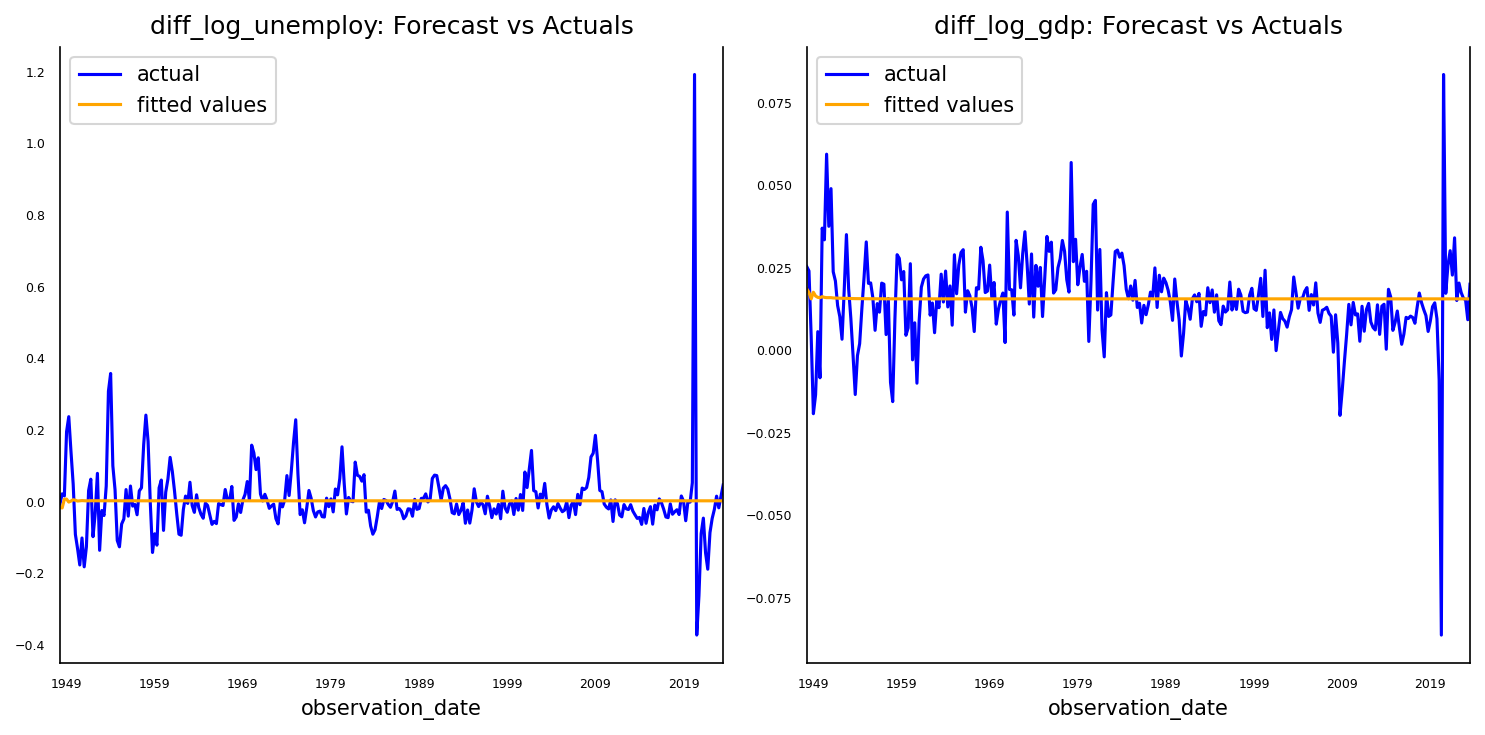

In [281]:
fig, axes = plt.subplots(nrows=int(len(col_to_use)/2), 
                         ncols=2, 
                         dpi=150, 
                         figsize=(10,5))


for i, (col,ax) in enumerate(zip(col_to_use, axes.flatten())):
    
    df_concat[col].plot(legend=True, 
                           ax=ax, 
                           color = "b", 
                           label = "actual")
    
    df_forecast[col].plot(legend=True, 
                          ax=ax, 
                          color = "orange", 
                          label = "fitted values").autoscale(axis='x',
                                                  tight=True);
    
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### ARIMA Modelling

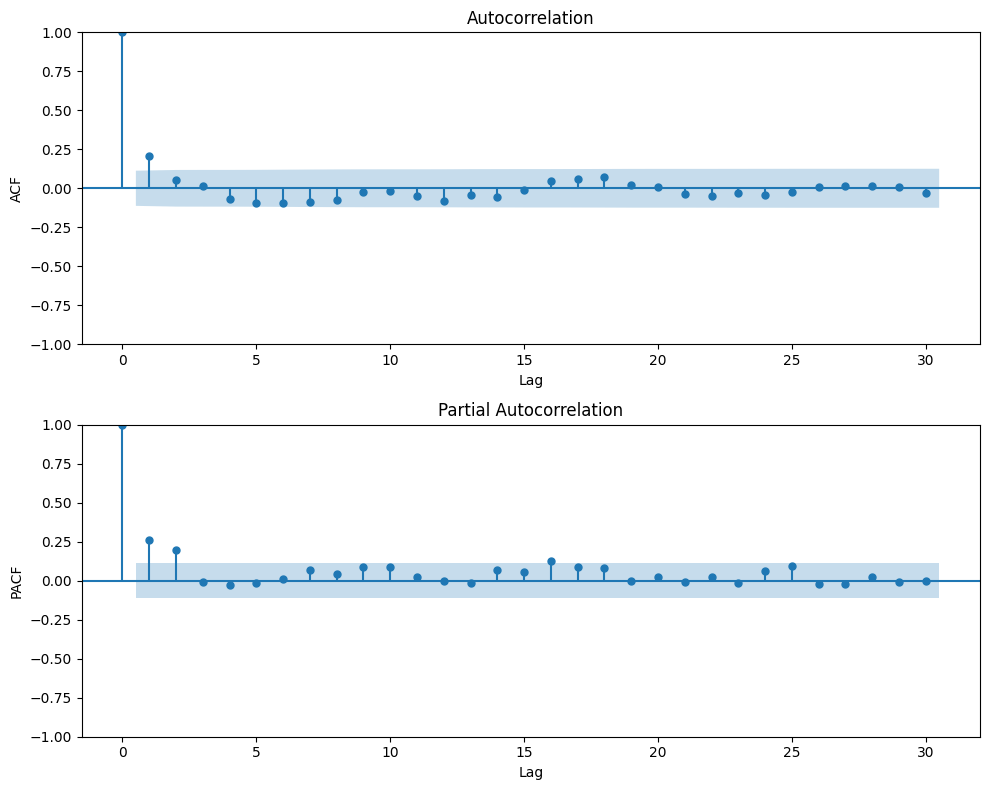

In [282]:
import statsmodels.api as sm
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_concat["diff_log_unemploy"], lags=30, ax=ax1)
plt.xlabel("Lag")
plt.ylabel("ACF")

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_concat["diff_log_gdp"], lags=30, ax=ax2)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout();
plt.show()

In [283]:
# infer frequency for modeling

model_arima = ARIMA(df_concat["diff_log_gdp"], 
                    order = (1,0,2)).fit()

print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:           diff_log_gdp   No. Observations:                  302
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 903.354
Date:                Sun, 07 Jan 2024   AIC                          -1796.708
Time:                        00:35:19   BIC                          -1778.156
Sample:                    06-30-1948   HQIC                         -1789.285
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0154      0.001     10.956      0.000       0.013       0.018
ar.L1          0.3965      0.234      1.696      0.090      -0.062       0.855
ma.L1         -0.1879      0.234     -0.805      0.4

In [178]:
df_concat

,UNEMPLOY,GDP,quarter,year,Trend_unemploy,Detrend_unemploy,Seasonal_unemploy,Residual_unemploy,Seasonal Adjusted,UNEMPLOY2,log_gdp,log_unemploy,diff_log_gdp,diff_log_unemploy
1948Q4,2324.0,280.366,4.0,1948.0,2347.625,-23.625,-41.988333,18.363333,2365.988333,5400976.0,5.636096,7.751045,0.004182,0.015612
1949Q1,2825.0,275.034,1.0,1949.0,2586.750,238.250,-59.951667,298.201667,2884.951667,7980625.0,5.616895,7.946264,-0.019201,0.195219
1949Q2,3581.0,271.351,2.0,1949.0,2983.250,597.750,129.271667,468.478333,3451.728333,12823561.0,5.603413,8.183397,-0.013482,0.237134
1949Q3,4118.0,272.889,3.0,1949.0,3462.125,655.875,20.680743,635.194257,4097.319257,16957924.0,5.609065,8.323123,0.005652,0.139726
1949Q4,4325.0,270.627,4.0,1949.0,3852.375,472.625,-41.988333,514.613333,4366.988333,18705625.0,5.600741,8.372167,-0.008324,0.049045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022Q3,5836.0,25994.639,3.0,2022.0,6105.875,-269.875,20.680743,-290.555743,12536.728333,34058896.0,10.165646,8.671801,0.017477,-0.021696
2022Q4,5925.0,26408.405,4.0,2022.0,5940.625,-15.625,-41.988333,26.363333,12536.728333,35105625.0,10.181438,8.686936,0.015792,0.015135
2023Q1,5823.0,26813.601,1.0,2023.0,5879.500,-56.500,-59.951667,3.451667,12536.728333,33907329.0,10.196665,8.669571,0.015227,-0.017365
2023Q2,5904.0,27063.012,2.0,2023.0,5915.625,-11.625,129.271667,-140.896667,12536.728333,34857216.0,10.205923,8.683385,0.009259,0.013814


<AxesSubplot:xlabel='observation_date'>

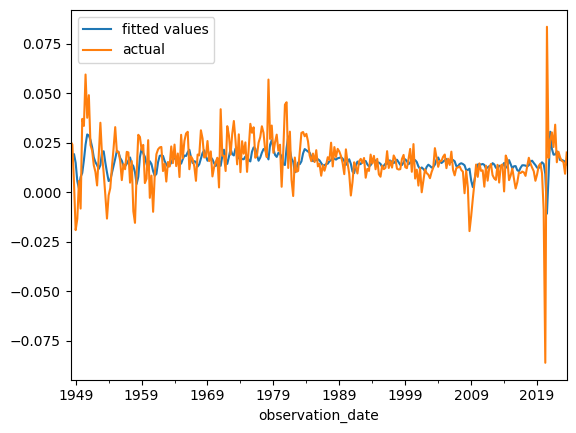

In [284]:
model_arima.fittedvalues.plot(label = "fitted values", legend = True)
df_concat["diff_log_gdp"].plot(label = "actual", legend = True)

In [285]:
rmse_arima = np.sqrt(mse(df_concat["diff_log_gdp"], model_arima.fittedvalues))
rmse_arima

0.012151740130555748

In [286]:
rmse_var = np.sqrt(mse(df_concat["diff_log_gdp"], df_forecast["diff_log_gdp"]))
rmse_var

0.012855562002787955

The performance that use only lag of GDP to forecast GDP have smaller RMSE, how about we use single model of multivariate autoregressive instead of VAR?

In [287]:
model_arima = ARIMA(exog = df_concat["diff_log_gdp"], 
                    endog = df_concat["diff_log_unemploy"], 
                    order = (2,0,2)).fit()

print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:      diff_log_unemploy   No. Observations:                  302
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 404.201
Date:                Sun, 07 Jan 2024   AIC                           -794.402
Time:                        00:35:31   BIC                           -768.429
Sample:                    06-30-1948   HQIC                          -784.010
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1013      0.022      4.614      0.000       0.058       0.144
diff_log_gdp    -6.3763      0.219    -29.150      0.000      -6.805      -5.948
ar.L1            0.5252      0.535      0.98

<AxesSubplot:xlabel='observation_date'>

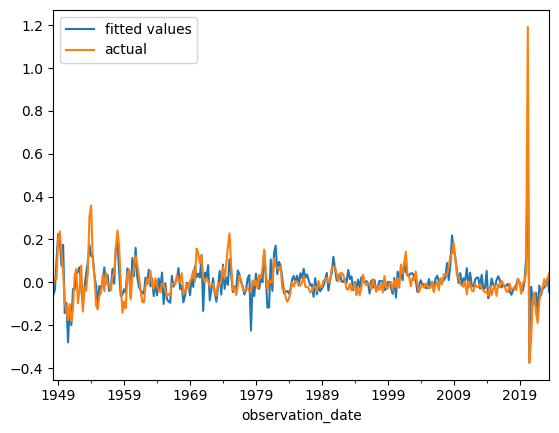

In [288]:
model_arima.fittedvalues.plot(label = "fitted values", legend = True)
df_concat["diff_log_unemploy"].plot(label = "actual", legend = True)

In [289]:
rmse_arima_multivariate = np.sqrt(mse(df_concat["diff_log_unemploy"], model_arima.fittedvalues))
rmse_arima_multivariate

0.06345917137837308

### Summary Evaluation

In [290]:
summary_rmse = pd.DataFrame([rmse_var,rmse_arima,rmse_arima_multivariate], 
                            columns = ["RMSE"],
                            index = ["VAR", "ARIMA", "Multivariate ARIMA"])

In [291]:
summary_rmse

,RMSE
VAR,0.012856
ARIMA,0.012152
Multivariate ARIMA,0.063459
